In [34]:
import os
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [ ]:
data= pd.read_csv('data/fer2013.csv')

In [11]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [8]:
train_set = data[(data.Usage == 'Training')] 
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [9]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [12]:
y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) 
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes) 
y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_classes) 

In [13]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

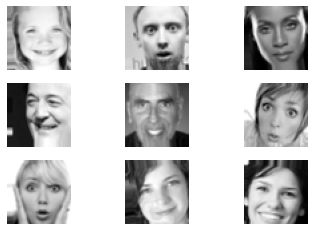

In [14]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break 

In [15]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

In [35]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)        

In [39]:
filepath = os.path.join("./emotion_detector_models/model_v6_{epoch}.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
# if mode == "train":
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
nb_train_samples = 28709
nb_validation_samples = 3589
epochs = 10
model_info = model.fit(
            train_flow,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=val_flow,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
448/448 [==============================] - 134s 298ms/step - loss: 1.9168 - accuracy: 0.2450 - val_loss: 1.8823 - val_accuracy: 0.2492
Epoch 2/10
448/448 [==============================] - 138s 309ms/step - loss: 1.8762 - accuracy: 0.2516 - val_loss: 1.8647 - val_accuracy: 0.2575
Epoch 3/10
448/448 [==============================] - 143s 318ms/step - loss: 1.8467 - accuracy: 0.2575 - val_loss: 1.8352 - val_accuracy: 0.2589
Epoch 4/10
356/448 [======================>.......] - ETA: 27s - loss: 1.8024 - accuracy: 0.2632

KeyboardInterrupt: 

In [40]:
model.load_weights(os.path.join("model_v6_23.hdf5"))

In [41]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=model_info.history['loss']
val_loss=model_info.history['val_loss']
train_acc=model_info.history['acc']
val_acc=model_info.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

NameError: name 'model_info' is not defined

In [42]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

In [43]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

113/113 [==============================] - 3s 29ms/step


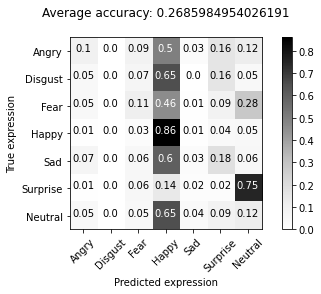

In [44]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')